<a href="https://colab.research.google.com/github/annasli378/analizaAK/blob/main/Iteracyjne_grid_search_po_cechach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 21 11:54:34 2023

@author: Ania
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn import metrics
from sklearn import svm
import joblib

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def hgbt_train(X, Y):
    # KFOLD
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    all_preds = np.zeros(Y.shape)
    all_tru = np.zeros(Y.shape)
    cnt=0
    for train, test in kfold.split(X, Y):
        X_fold = X[train, :]
        Y_fold = Y[train]
        model = HistGradientBoostingClassifier().fit(X_fold, Y_fold.ravel())

        X_test = X[test, :]
        Y_test1 = Y[test]
        preds_test = model.predict(X_test)

        for c in range(0, len(preds_test)):
            all_preds[cnt] = preds_test[c]
            all_tru[cnt] = Y_test1[c]
            cnt=cnt+1
    return metrics.balanced_accuracy_score(all_tru, all_preds)


def svn_train(X, Y, gamma, C, kernel='rbf'):
    # KFOLD
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    all_preds = np.zeros(Y.shape)
    all_tru = np.zeros(Y.shape)
    cnt=0
    for train, test in kfold.split(X, Y):
        X_fold = X[train, :]
        Y_fold = Y[train]
        model = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X_fold, Y_fold.ravel())

        X_test = X[test, :]
        Y_test1 = Y[test]
        preds_test = model.predict(X_test)
        for c in range(0, len(preds_test)):
            all_preds[cnt] = preds_test[c]
            all_tru[cnt] = Y_test1[c]
            cnt=cnt+1
    return metrics.balanced_accuracy_score(all_tru, all_preds)


def rf_train(X, Y,crit):
    # KFOLD
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    all_preds = np.zeros(Y.shape)
    all_tru = np.zeros(Y.shape)
    cnt=0
    for train, test in kfold.split(X, Y):
        X_fold = X[train, :]
        Y_fold = Y[train]
        model = RandomForestClassifier( criterion = crit).fit(X_fold, Y_fold.ravel())

        X_test = X[test, :]
        Y_test1 = Y[test]
        preds_test = model.predict(X_test)

        for c in range(0, len(preds_test)):
            all_preds[cnt] = preds_test[c]
            all_tru[cnt] = Y_test1[c]
            cnt=cnt+1
    return metrics.balanced_accuracy_score(all_tru, all_preds)


def knn_train(X, Y, n, algo = 'auto'):
    # KFOLD
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    all_preds = np.zeros(Y.shape)
    all_tru = np.zeros(Y.shape)
    cnt=0
    for train, test in kfold.split(X, Y):
        X_fold = X[train, :]
        Y_fold = Y[train]

        model = KNeighborsClassifier(n_neighbors=n, algorithm = algo).fit(X_fold, Y_fold.ravel())
        X_test = X[test, :]
        Y_test1 = Y[test]
        preds_test = model.predict(X_test)

        for c in range(0, len(preds_test)):
            all_preds[cnt] = preds_test[c]
            all_tru[cnt] = Y_test1[c]
            cnt=cnt+1

    return metrics.balanced_accuracy_score(all_tru, all_preds)

In [4]:
def iterative_training(rescaledX, k):
  hgbt_tmp=[]
  knn_tmp=[]
  rf_tmp=[]
  svn_tmp=[]

  for i in range(1,k):
   # print(f'{i}/{k}')
    X_new = rescaledX[:, 0:i]

    acchgbt = hgbt_train(X_new, Y_train)
    hgbt_tmp.append({'ft_num': i, 'name':'HGBT','acc': acchgbt})

    for n in range(1,6):
        accknn = knn_train(rescaledX, Y_train, n)
        knn_tmp.append({'ft_num': i, 'name':'KNN', 'n': n ,'acc': accknn})

    for cit in ['gini', 'entropy', 'log_loss']:
        accrf = rf_train(rescaledX, Y_train, crit=cit)
        rf_tmp.append({'ft_num': i, 'name':'RF', 'criterion': cit, 'acc': accrf})

    for C in [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]:
        for gamma in [0.01, 0.05, 0.1, 0.5, 1]:
            accsvn = svn_train(rescaledX, Y_train, gamma=gamma, C=C)
            svn_tmp.append({'ft_num': i, 'name':'SVN', 'C': C ,'gamma': gamma, 'acc': accsvn})


  HGBT_res = pd.DataFrame(hgbt_tmp)
  maxidx_hgbt = HGBT_res['acc'].idxmax()
  print(f"HGBT acc max: { HGBT_res['acc'].iloc[maxidx_hgbt]}, number of features: { HGBT_res['ft_num'].iloc[maxidx_hgbt] } ")
  HGBT_res.plot(kind='scatter', x='ft_num', y='acc', s=32, alpha=.8)
  plt.title('HGBT')
  plt.gca().spines[['top', 'right',]].set_visible(False)

  KNN_res = pd.DataFrame(knn_tmp)
  maxidx_knn= KNN_res['acc'].idxmax()
  print(f"KNN acc max: { KNN_res['acc'].iloc[maxidx_knn]}, number of features: { KNN_res['ft_num'].iloc[maxidx_knn]} , n = {KNN_res['n'].iloc[maxidx_knn]} ")

  KNN_res.plot(kind='scatter', x='ft_num', y='acc', s=32, alpha=.8)
  plt.title('KNN')
  plt.gca().spines[['top', 'right',]].set_visible(False)


  RF_res = pd.DataFrame(rf_tmp)
  maxidx_rf= RF_res['acc'].idxmax()
  print(f"RF acc max: { RF_res['acc'].iloc[maxidx_rf]}, number of features: { RF_res['ft_num'].iloc[maxidx_rf]}, criterion: { RF_res['criterion'].iloc[maxidx_rf]} ")
  RF_res.plot(kind='scatter', x='ft_num', y='acc', s=32, alpha=.8)
  plt.title('RF')
  plt.gca().spines[['top', 'right',]].set_visible(False)



  SVN_res = pd.DataFrame(svn_tmp)
  maxidx_svn= SVN_res['acc'].idxmax()
  print(f"SVN acc max: { SVN_res['acc'].iloc[maxidx_svn]}, number of features: { SVN_res['ft_num'].iloc[maxidx_svn]}, C: { SVN_res['C'].iloc[maxidx_svn]}, gamma: { SVN_res['gamma'].iloc[maxidx_svn]} ")
  SVN_res.plot(kind='scatter', x='ft_num', y='acc', s=32, alpha=.8)
  plt.title('SVN')
  plt.gca().spines[['top', 'right',]].set_visible(False)


In [16]:
def get_X(path_to_data, Y_train):
  X_train = pd.read_csv(path_to_data, header=None)
  X_train = X_train.values
  X_train2=X_train[Y_train>0]
  Y_train2 = Y_train[Y_train>0]
  scaler = MinMaxScaler(feature_range=(0, 1))
  rescaledX = scaler.fit_transform(X_train2)
  [w, k] = X_train.shape
  print(f"ft num:{k}")
  return X_train2, Y_train2, k

In [28]:
path_to_data = "/content/drive/MyDrive/USG/analiza_AK/kolejnosc/dane_anova_tuckey_1vs2_"
path_to_Y = "/content/drive/MyDrive/USG/analiza_AK/cechy/names_Y.csv"
path_to_models = "/content/drive/MyDrive/USG/analiza_AK/modele/"

In [ ]:
# pierwszy testowany plik:
path_to_data = "/content/drive/MyDrive/USG/analiza_AK/kolejnosc/dane_anova_tuckey_2vs3_"
path_to_Y = "/content/drive/MyDrive/USG/analiza_AK/cechy/names_Y.csv"
path_to_models = "/content/drive/MyDrive/USG/analiza_AK/modele/"
#X_train = pd.read_csv(path_to_data, header=None)
Y_train = pd.read_csv(path_to_Y, header=None)
Y_train = Y_train[1]

# połączenie ak2 i ak3 w jedną klasę:
#Y_train[Y_train==2]=1
#Y_train[Y_train==3]=2
Y_train = Y_train.values -1


rescaledX, Y_train, k = get_X(path_to_data+'RelefF.csv', Y_train)
print(rescaledX.shape)
iterative_training(rescaledX, k)

ft num:59
(143, 59)


In [30]:
rescaledX, Y_train, k = get_X(path_to_data+'RMRM.csv', Y_train)

ft num:8


In [31]:
rescaledX.shape

(143, 8)

Poszukiwania dobrego i - ile cech się nada w klasyfikacji

HGBT acc max: 0.5666666666666667, number of features: 6 
KNN acc max: 0.618969298245614, number of features: 1 , n = 5 
RF acc max: 0.587719298245614, number of features: 5, criterion: gini 
SVN acc max: 0.5828947368421052, number of features: 1, C: 2.0, gamma: 0.1 


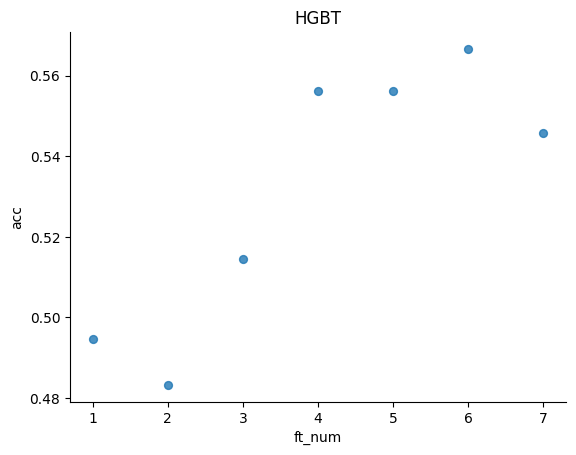

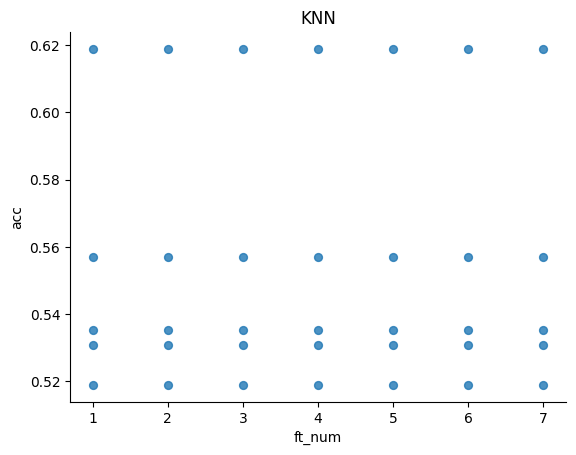

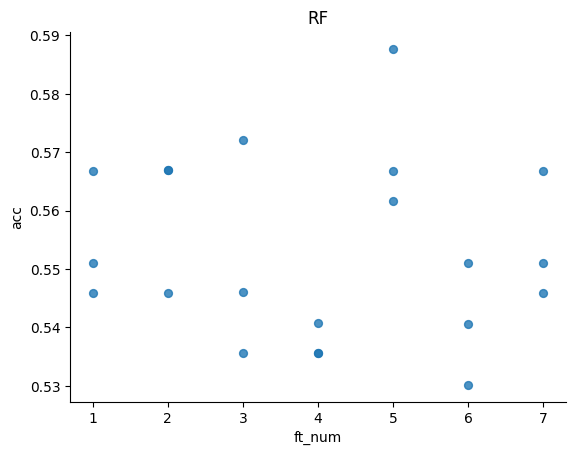

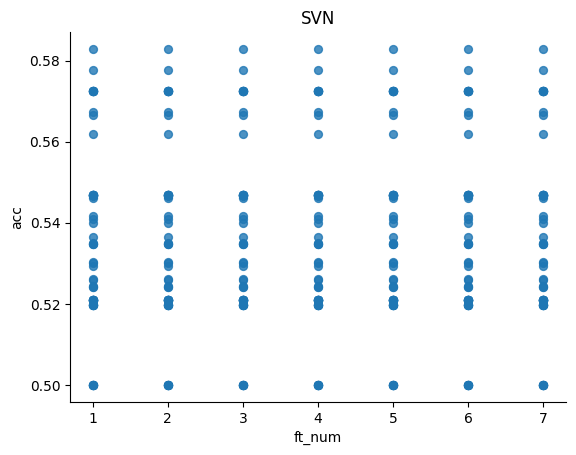

In [32]:
iterative_training(rescaledX, k)

ft num:50
HGBT acc max: 0.6872814685314685, number of features: 15 
KNN acc max: 0.58631993006993, number of features: 1 , n = 1 
RF acc max: 0.6700174825174825, number of features: 47, criterion: gini 
SVN acc max: 0.6630244755244755, number of features: 1, C: 10.0, gamma: 0.1 


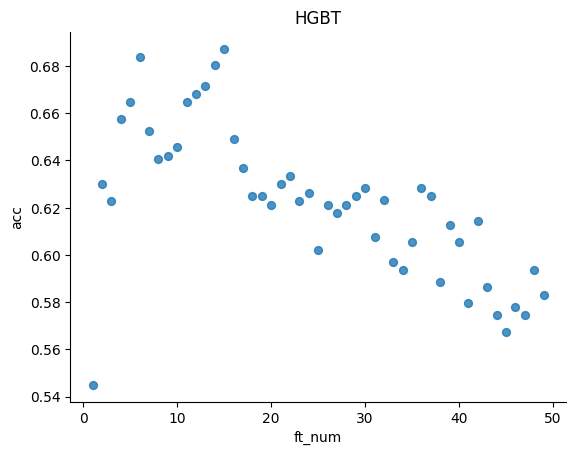

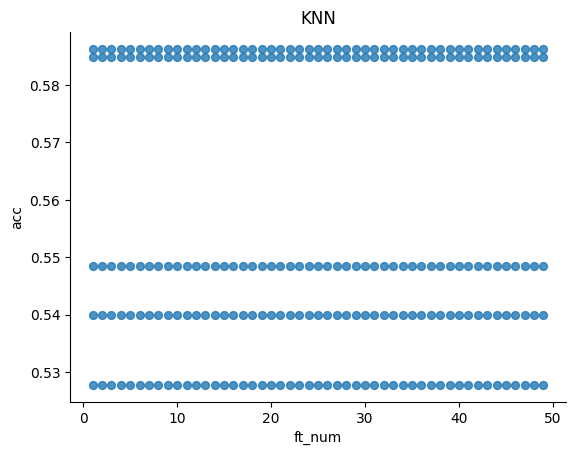

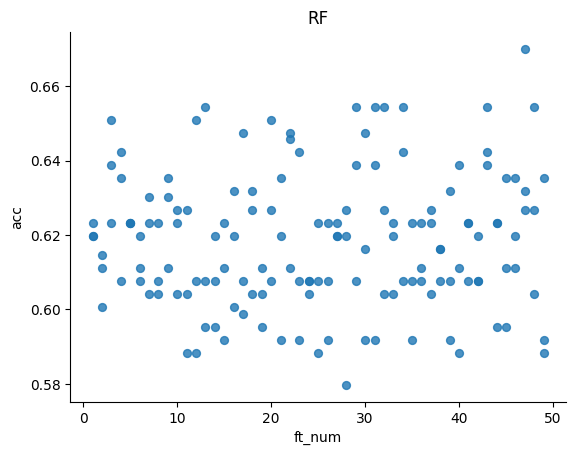

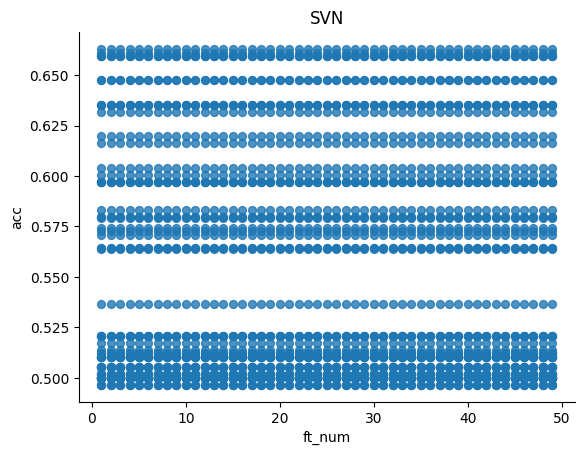

In [10]:
rescaledX, k = get_X(path_to_data+'CHI2.csv')
iterative_training(rescaledX, k)

ft num:50
HGBT acc max: 0.6439029720279721, number of features: 40 
KNN acc max: 0.58631993006993, number of features: 1 , n = 1 
RF acc max: 0.6700174825174825, number of features: 3, criterion: gini 
SVN acc max: 0.6630244755244755, number of features: 1, C: 10.0, gamma: 0.1 


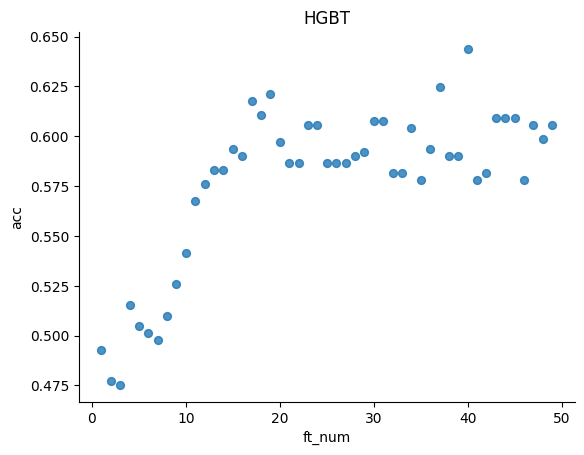

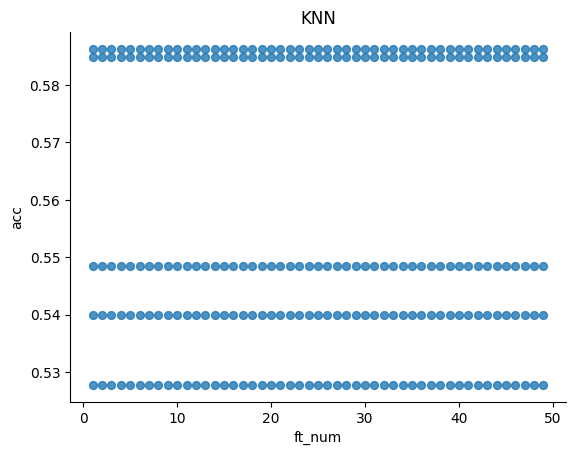

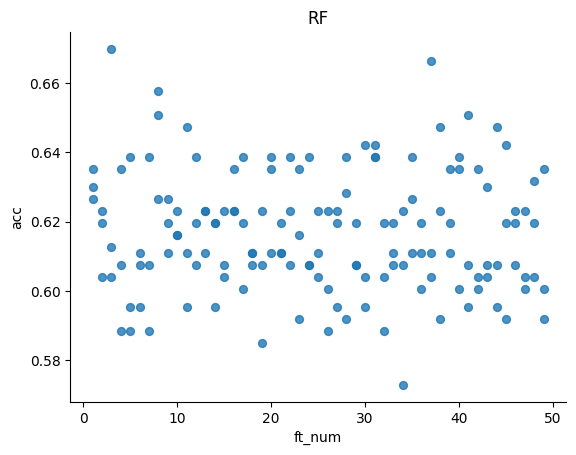

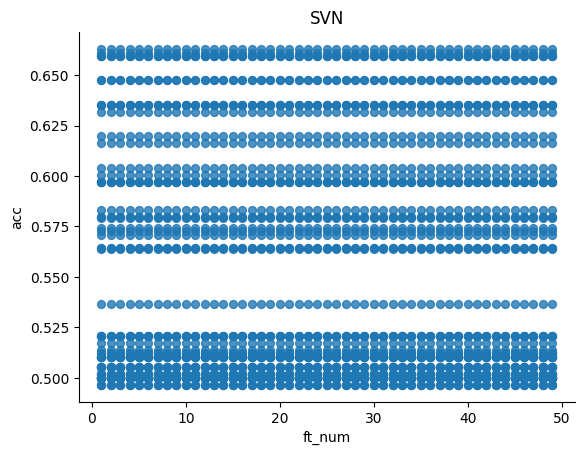

In [11]:
rescaledX, k = get_X(path_to_data+'RelefF.csv')
iterative_training(rescaledX, k)